In [59]:
!pip install matplotlib

In [100]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [137]:
# Construction du Discriminateur
def build_discriminator(img_shape=(28, 28, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Construction du Générateur
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Chargement et Redimensionnement des Images
def load_real_samples(img_size=(28, 28)):
    data_dir = "./pokemon/pokemon"  # Répertoire contenant les images

    # Chargement et redimensionnon des images
    images = []
    for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, filename))
        img = img.convert('L')  # Convertion en niveaux de gris
        img = img.resize(img_size, Image.LANCZOS)  # Redimension de l'image avec la méthode LANCZOS
        img = np.array(img)  # Convertion l'image en tableau numpy
        img = np.expand_dims(img, axis=-1)  # Ajout d'une dimension pour le canal de couleur
        images.append(img)

    # Convertion de la liste d'images en un tableau numpy
    images = np.array(images)

    # Normalisation des valeurs des pixels entre -1 et 1
    images = (images.astype(np.float32) - 127.5) / 127.5
    
    return images

# Construction du Modèle GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan_model = models.Model(gan_input, gan_output)
    gan_model.compile(loss='binary_crossentropy', optimizer='adam')
    return gan_model

# Fonction pour générer des exemples de données aléatoires
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Entraînement du GAN
def train_gan(generator, discriminator, gan_model, latent_dim, X_real, n_epochs=100, batch_size=128):
    half_batch = int(batch_size / 2)
    for epoch in range(n_epochs):
        for i in range(len(X_real) // batch_size):
            # Sélection d'un sous-ensemble aléatoire des images réelles
            ix = np.random.randint(0, X_real.shape[0], half_batch)
            X_real_batch = X_real[ix]
            # Génération des exemples de données latentes aléatoires
            X_fake_batch = generate_latent_points(latent_dim, half_batch)
            # Génération des exemples de données Pokémon synthétiques
            X_fake_batch = generator.predict(X_fake_batch)
            # Création des étiquettes pour les données réelles et synthétiques
            y_real = np.ones((half_batch, 1))
            y_fake = np.zeros((half_batch, 1))
            # Entraînenement du discriminateur sur les données réelles
            d_loss_real = discriminator.train_on_batch(X_real_batch, y_real)
            # Entraînenement du discriminateur sur les données synthétiques
            d_loss_fake = discriminator.train_on_batch(X_fake_batch, y_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Préparation des points de données latentes comme entrée pour le GAN
            X_gan = generate_latent_points(latent_dim, batch_size)
            # Création des étiquettes trompeuses pour les données générées par le générateur
            y_gan = np.ones((batch_size, 1))
            # Entraînenement du générateur via le modèle GAN
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Affichage de la progression de l'entraînement
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(X_real) // batch_size}, D Loss={d_loss}, G Loss={g_loss}")

# Paramètres du modèle GAN
latent_dim = 100
resolution = 28

# Chargement des données réelles
X_real = load_real_samples()

# Construction du générateur
generator = build_generator(latent_dim)

# Construction du discriminateur
discriminator = build_discriminator((resolution, resolution, 1))

# Construction du modèle GAN
gan_model = build_gan(generator, discriminator)

# Paramètres d'entraînement
n_epochs = 100
batch_size = 128

# Compilation du modèle du discriminateur
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Entraînement du modèle GAN
train_gan(generator, discriminator, gan_model, latent_dim, X_real, n_epochs=n_epochs, batch_size=batch_size)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1, Batch 1/6, D Loss=0.765277624130249, G Loss=[array(0.7383207, dtype=float32), array(0.7383207, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1, Batch 2/6, D Loss=0.7508327960968018, G Loss=[array(0.7417258, dtype=float32), array(0.7417258, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1, Batch 3/6, D Loss=0.7457495927810669, G Loss=[array(0.74092895, dtype=float32), array(0.74092895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1, Batch 4/6, D Loss=0.745781660079956, G Loss=[array(0.7429997, dtype=float32), array(0.7429997, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1, Batch 5/6, D Loss=0.7466668486595154, G Loss=[array(0.7447568, dtype=float32), array(0.7447568, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1, Batch 6/6, D Loss=0.7464208006858826, G Loss=[array(0.74539995, dtype=float32), array(0.74539995, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 2, Batch 1/6, D Loss=0.749881982803344

In [138]:
# Générer une image Pokémon aléatoire
random_pokemon = generate_random_pokemon(generator, latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


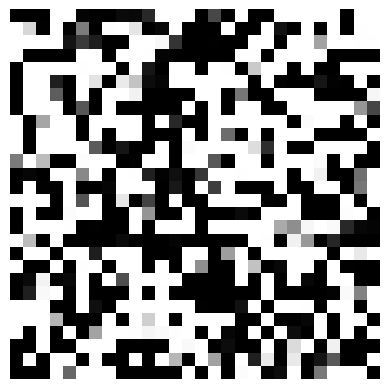

In [139]:
# Afficher l'image générée
display_pokemon(random_pokemon)

In [144]:
def build_progressive_generator(latent_dim, resolution=4):
    model = Sequential()

    # Initial layer
    model.add(Dense(4 * 4 * 512, input_dim=latent_dim))
    model.add(Reshape((4, 4, 512)))

    # Progressive layers
    while resolution <= 64:
        model.add(UpSampling2D())
        model.add(Conv2D(512, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        resolution *= 2

    # Output layer
    model.add(Conv2D(3, kernel_size=3, activation='tanh', padding='same'))

    return model

def build_progressive_discriminator(resolution=4):
    model = Sequential()

    # Progressive layers
    while resolution <= 64:
        model.add(Conv2D(512, kernel_size=3, input_shape=(resolution, resolution, 1), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        resolution *= 2

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

In [145]:
# Paramètres d'entraînement
latent_dim = 100
start_resolution = 4
end_resolution = 64
n_epochs = 100
batch_size = 128

# Construction du générateur progressif
generator = build_progressive_generator(latent_dim, start_resolution)

# Construction du discriminateur progressif
discriminator = build_progressive_discriminator(start_resolution)

# Construction du modèle GAN progressif
gan_model = define_gan(generator, discriminator)

# Entraînement du GAN progressif
train_progressive_gan(generator, discriminator, gan_model, latent_dim, n_epochs, batch_size, start_resolution, end_resolution)

ValueError: Input 0 of layer "conv2d_27" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 8192)